In [5]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
num_folds = 5
k = 1
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 16

Dataset_Name = f"Lung.Colon.Cancer.Hist.{num_folds}k{str(k)}"
work_dir = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/"
base_dir = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all/"

print(f"Dataset_Name = {Dataset_Name}")

Dataset_Name = Lung.Colon.Cancer.Hist.5k1


In [7]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

In [8]:
csv_file = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all.csv"
df_original = pd.read_csv(csv_file) # , delimiter = " ", header=None
#train_df_original.columns = ['Column_1', 'filename', 'label', 'Column_2']
df_original.head()

,Unnamed: 0,path,label
0,0,colon_n/colonn4479.jpeg,colon_n
1,1,colon_n/colonn4571.jpeg,colon_n
2,2,colon_n/colonn4546.jpeg,colon_n
3,3,colon_n/colonn4467.jpeg,colon_n
4,4,colon_n/colonn4634.jpeg,colon_n


In [9]:
df_full_path = df_original.copy()

#'''
for i in range(df_original.shape[0]):
    filename = df_original['path'][i]
    file_full_path = f"{base_dir}{filename}"
    df_full_path['path'][i] = file_full_path
#'''
    
print(f"df_full_path['path'][0] = {df_full_path['path'][0]}")
df_full_path.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


df_full_path['path'][0] = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all/colon_n/colonn4479.jpeg


,Unnamed: 0,path,label
24995,24995,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24996,24996,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24997,24997,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24998,24998,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24999,24999,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca


In [10]:
df_full_path['label'] = df_full_path['label'].astype(str)

In [11]:
list_classes = np.unique(df_full_path.label.values)
list_classes

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
      dtype=object)

In [12]:
list_train_indices = []
list_val_indices = []

for category in list_classes:
    df_category = df_full_path[df_full_path['label'] == category]
    print(f"category -> {category}: {df_category.shape[0]}:")

    #'''
    list_indices = list(df_category[['Unnamed: 0']].values)
    #print(f"list_indices[0][0] = {list_indices[0][0]}")
    #print(f"list_indices[-1][0] = {list_indices[-1][0]}")

    split_indices = int(df_category.shape[0]/num_folds)
    
    train_indices = list_indices[:k*split_indices-split_indices]
    train_indices += list_indices[k*split_indices:]
    val_indices = list_indices[k*split_indices-split_indices:k*split_indices]
    print(f"len(train_indices): {len(train_indices)}")
    print(f"len(val_indices): {len(val_indices)}\n")

    for index in train_indices:
        list_train_indices.append(index[0])
    
    for index in val_indices:
        list_val_indices.append(index[0])
    #'''

print(f"len(list_train_indices): {len(list_train_indices)}")
print(f"len(list_val_indices): {len(list_val_indices)}")

category -> colon_aca: 5000:
len(train_indices): 4000
len(val_indices): 1000

category -> colon_n: 5000:
len(train_indices): 4000
len(val_indices): 1000

category -> lung_aca: 5000:
len(train_indices): 4000
len(val_indices): 1000

category -> lung_n: 5000:
len(train_indices): 4000
len(val_indices): 1000

category -> lung_scc: 5000:
len(train_indices): 4000
len(val_indices): 1000

len(list_train_indices): 20000
len(list_val_indices): 5000


In [13]:
train_df = df_full_path[pd.DataFrame(df_full_path['Unnamed: 0'].tolist()).isin(list_train_indices).any(1).values]
print(f"train_df.shape = {train_df.shape}")
train_df.head() 

train_df.shape = (20000, 3)


,Unnamed: 0,path,label
1000,1000,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
1001,1001,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
1002,1002,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
1003,1003,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
1004,1004,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n


In [14]:
test_df = df_full_path[pd.DataFrame(df_full_path['Unnamed: 0'].tolist()).isin(list_val_indices).any(1).values]
print(f"test_df.shape = {test_df.shape}")
test_df.tail()

test_df.shape = (5000, 3)


,Unnamed: 0,path,label
20995,20995,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20996,20996,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20997,20997,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20998,20998,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20999,20999,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca


In [15]:
img_path = test_df['path'][20995]
img_path

'drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all/colon_aca/colonca1775.jpeg'

In [16]:
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img.shape

(768, 768, 3)

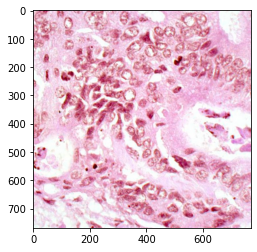

In [17]:
plt.imshow(img)

Bilinear is the standard resizing algorithm — good for most uses. Lanczos better preserves small details when upscaling and downscaling. And Nearest Neighbor is great for pixel art!

In [18]:
'''
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True, 
vertical_flip=True,
#rotation_range=20,
'''

train_datagen = ImageDataGenerator(rescale=1./255,
                                   #fill_mode="lanczos",
                                   )
test_datagen = ImageDataGenerator(rescale=1./255,
                                  #fill_mode="lanczos",
                                  )

In [19]:
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=None,
        x_col='path', 
        y_col='label',
        target_size=(768, 768),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = True,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical' # categorical, raw
        )

Found 20000 validated image filenames belonging to 5 classes.


In [20]:
num_classes = len(train_generator.class_indices)
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 20000
train_generator.image_shape = (768, 768, 3)
num_classes = 5


In [21]:
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=None,
        x_col='path', 
        y_col='label',
        target_size=(768, 768),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical')

Found 5000 validated image filenames belonging to 5 classes.


In [22]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 5000


In [23]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "noTL.Custom1" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{train_generator.image_shape[1]}p.DataFlow" # +str(img_size)+"p"
dataset

'Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow'

In [24]:
'''
count_no_improvement = 0
epoch_initial = True
#'''

'\ncount_no_improvement = 0\nepoch_initial = True\n#'

In [25]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 300 # 300, 5
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "None" # "imagenet" None
modelExt = "" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".run_1" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5
log_name = log.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.log


In [26]:
train_generator.image_shape

(768, 768, 3)

In [27]:
"""
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#"""

"\n#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)\n#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])\n# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121\n#inputs = Input(final_train_imageset.shape[1:])\n#x = ZeroPadding2D(padding=(pad,pad))(inputs)\n#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)\nbase_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)\nx=base_model.output\n\nx = Flatten()(x)\n\n#'''\nx = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)\n#x_copy = x\nx = Dropout(DROPOUT)(x)\nx = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)\nx = Dropout(DROPOUT)

In [28]:
inputs = Input(train_generator.image_shape)
x = inputs

x = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), padding='valid')(x)
x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('elu')(x)

x = Flatten()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val))(x)
x = Activation('elu')(x)

outputs = Dense(num_classes, activation='softmax')(x)
model=Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 766, 766, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 766, 766, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 383, 383, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 383, 383, 16)      2320      
_________________________________________________________________
activation_1 (Activation)    (None, 383, 383, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 191, 191, 16)      0     

In [29]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [30]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 36
Total number of layers = 36


In [31]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [32]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


In [33]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [34]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
#'''
count_no_improvement = 1 # 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 1


In [35]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 46
checkpointer_name = weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5


In [36]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=test_generator,
                        validation_steps=total_test_data // BATCH_SIZE,
                        verbose = 1,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5
Previously completed epochs = 46
count_no_improvement = 1 

Epoch 1/254
1250/1250 [==============================] - 11846s 9s/step - loss: 0.3046 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9937 - auc: 0.9999 - true_positives: 19875.0000 - true_negatives: 79877.0000 - false_positives: 123.0000 - false_negatives: 125.0000 - val_loss: 0.3428 - val_accuracy: 0.9786 - val_precision: 0.9793 - val_recall: 0.9780 - val_auc: 0.9989 - val_true_positives: 4882.0000 - val_true_negatives: 19865.0000 - val_false_positives: 103.0000 - val_false_negatives: 110.0000

Epoch 00001: saving model to drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5


KeyboardInterrupt: ignored

In [37]:
# weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5


In [38]:
'''
Record: Lung_Colon_Cancer_Hist_5_folds_k1_impl_1_768p_RGB_Custom_noTL_DataFrame: 
(Accuracy: 96.33%, Precision: 96.39%, Recall: 96.37%, F-Measure: 96.38%):
---

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, Precision: {}, Recall: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[2],4), round(result[3],4), round(result[0],4), epochs_completed, checkpointer_name))
#'''

'\ncsv_logger = CSVLogger(work_dir+log_name, separator=\',\', append=True)\nlog_data = pd.read_csv(work_dir+log_name, sep=\',\', usecols=[\'epoch\'], engine=\'python\')\nepochs_completed = log_data.shape[0]\n\nresult = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)\nprint("Test Acc: {}, Precision: {}, Recall: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[2],4), round(result[3],4), round(result[0],4), epochs_completed, checkpointer_name))\n#'

In [39]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/best_weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5.


In [41]:
'''
Record: Lung_Colon_Cancer_Hist_5_folds_k1_impl_1_768p_RGB_Custom_noTL_DataFrame: 
(Accuracy: 96.33%, Precision: 96.39%, Recall: 96.37%, F-Measure: 96.38%):
---

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Precision: {}, Recall: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[2],4), round(result2[3],4), round(result2[0],4), epochs_completed, checkpointer_name))


312/312 [==============================] - 97s 310ms/step - loss: 0.3157 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9981 - true_positives: 4876.0000 - true_negatives: 19852.0000 - false_positives: 116.0000 - false_negatives: 116.0000
Test Acc: 0.9768, Precision: 0.9768, Recall: 0.9768, Test Loss: 0.3157: ep46, weights.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.hdf5



In [42]:
# metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
result2

[0.3156625032424927,
 0.9767628312110901,
 0.9767628312110901,
 0.9767628312110901,
 0.9980944395065308,
 4876.0,
 19852.0,
 116.0,
 116.0]

In [69]:
TP = result2[5]
TN = result2[6]
FP = result2[7]
FN = result2[8]
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")

TP=4876.0, TN=19852.0, FP=116.0, FN=116.0


In [70]:
'''
run_1: accuracy=0.9768, sensitivity=recall=0.9768, specificity=0.9942, precision=0.9768, f1_score=0.9768, auc=0.9768

'''

'\nrun_1: \n\n'

In [71]:
accuracy = round(result2[1], 4)
sensitivity = round((TP / (TP+FN)), 4)
specificity = round((TN / (FP+TN)), 4)
precision = round((TP / (TP+FP)), 4)
recall = sensitivity # sensitivity and recall are same.
f1_score = round((2*precision*recall) / (precision+recall), 4)
auc = round(result2[2], 4)

print(f"accuracy={accuracy}, sensitivity=recall={sensitivity}, specificity={specificity}, precision={precision}, f1_score={f1_score}, auc={auc}")

accuracy=0.9768, sensitivity=recall=0.9768, specificity=0.9942, precision=0.9768, f1_score=0.9768, auc=0.9768


In [72]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [73]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


313/313 [==============================] - 88s 280ms/step
Saved: drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Y_pred.Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1


In [74]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

'\nsave_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"\nnp.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)\nprint(f"Saved: {work_dir}{save_predictions_filename}")\n#'

In [75]:
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename_2}.npy", allow_pickle=True)
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (5000, 5)


In [76]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [77]:
y_true = test_generator.classes

In [78]:
list_class_names_in_generator = list(test_generator.class_indices.values())
list_class_names_in_generator[:5]

[0, 1, 2, 3, 4]

In [79]:
len(list_class_names_in_generator)

5

In [80]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [81]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (5000,)
np_y_pred_rearranged.shape = (5000,)
np_y_true_rearranged: [1 1 1 ... 0 0 0]
np_y_pred_rearranged: [1 1 1 ... 0 0 0]


In [82]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (5000,)

y_true[-5:] = [0, 0, 0, 0, 0]
y_pred[-5:] = [0 0 0 0 0]

np_y_true_rearranged[-5:] = [0 0 0 0 0]
np_y_pred_rearranged[-5:] = [0 0 0 0 0]

np.unique(np_y_true_rearranged) = [0 1 2 3 4]
np.unique(np_y_pred_rearranged) = [0 1 2 3 4]


In [83]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[990   8   0   1   1]
 [ 11 989   0   0   0]
 [  0   0 939   4  57]
 [  0   0   2 998   0]
 [  0   0  32   0 968]]


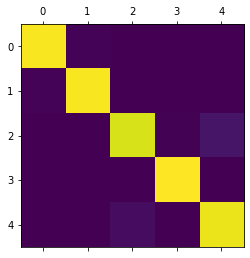

In [84]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [85]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/conf_matrix_Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.png


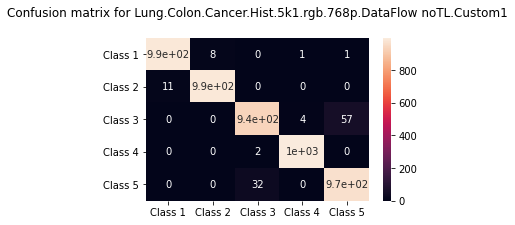

In [86]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (5,3))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'Images/conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [87]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(sklearn.metrics.confusion_matrix(np_test_label, y_pred))\n#"

In [88]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

"\nprint('Classification Report:')\nprint(sklearn.metrics.classification_report(test_generator.classes, y_pred))\n#"

In [89]:
test_generator.class_indices.keys()

dict_keys(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'])

In [90]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

   colon_aca       0.99      0.99      0.99      1000
     colon_n       0.99      0.99      0.99      1000
    lung_aca       0.97      0.94      0.95      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.94      0.97      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [91]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [92]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,auc,false_negatives,false_positives,loss,precision,recall,true_negatives,true_positives,val_accuracy,val_auc,val_false_negatives,val_false_positives,val_loss,val_precision,val_recall,val_true_negatives,val_true_positives
0,0,0.71830,0.943623,7414.0,3279.0,4.994125,0.793319,0.62930,76721.0,12586.0,0.870793,0.984382,664.0,627.0,4.499894,0.873461,0.866987,19341.0,4328.0
1,1,0.86965,0.985153,2674.0,2543.0,4.327326,0.872012,0.86630,77457.0,17326.0,0.870793,0.987281,652.0,629.0,4.146971,0.873415,0.869391,19339.0,4340.0
2,2,0.88725,0.988203,2303.0,2199.0,3.990505,0.889475,0.88485,77801.0,17697.0,0.911659,0.991388,453.0,431.0,3.809420,0.913280,0.909255,19537.0,4539.0
3,3,0.90035,0.990169,2034.0,1953.0,3.690166,0.901953,0.89830,78047.0,17966.0,0.894030,0.991123,536.0,518.0,3.550980,0.895858,0.892628,19450.0,4456.0
4,4,0.90660,0.991661,1896.0,1827.0,3.419344,0.908334,0.90520,78173.0,18104.0,0.923277,0.994027,387.0,375.0,3.269017,0.924699,0.922476,19593.0,4605.0


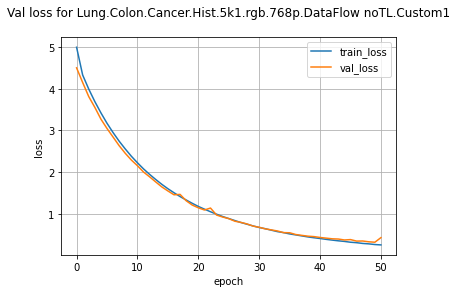

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/vLoss_Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.png


In [93]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

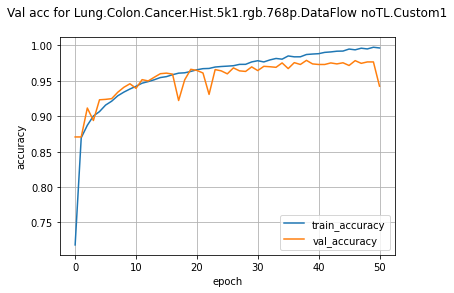

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/vAcc_Lung.Colon.Cancer.Hist.5k1.rgb.768p.DataFlow.pad0.noTL.Custom1.wInit.None.TrainableAfter.allDefault.actF.elu.opt.Adam.drop.0.5.batch16.run_1.png


In [94]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)